## Dataset Loading

In [1]:
# Load Dataset
import tensorflow as tf

# Balance
train_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/train'
val_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/val'
test_dir = '/kaggle/input/tomatodiseasedataset/TomatoDiseaseSplit/test'

# Define parameters
BATCH_SIZE = 32
IMG_SIZE = (256, 256)  # Image dimensions

# Load the train dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    shuffle=True,
                                                                    batch_size=BATCH_SIZE,
                                                                    image_size=IMG_SIZE)

# Load the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                  shuffle=True,
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                   shuffle=False,
                                                                   batch_size=BATCH_SIZE,
                                                                   image_size=IMG_SIZE)

Found 9973 files belonging to 10 classes.
Found 1595 files belonging to 10 classes.
Found 1607 files belonging to 10 classes.


In [2]:
# Print class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [3]:
# Define normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to each dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [4]:
# Define input shape, number of classes and batch size
input_shape = (256, 256, 3)
num_classes = 10  
batch_size = 32

## Inception Model

In [ ]:
import keras_tuner as kt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define the model-building function
def build_model(hp):
    # Load the pre-trained InceptionV3 model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze the base model layers
    
    # Use Functional API to build the model
    inputs = tf.keras.Input(shape=(256, 256, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(hp.Float('dropout_rate_1', 0.3, 0.7, step=0.1))(x)
    x = layers.Dense(hp.Int('dense_units', 64, 256, step=32), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_rate_2', 0.2, 0.5, step=0.1))(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Instantiate RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy', 
    executions_per_trial=1, 
    max_trials=10,  
    directory='tuner_results',
    project_name='inceptionv3_random_search'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Run the random search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping,reduce_lr]
)

Trial 10 Complete [00h 06m 25s]
val_accuracy: 0.863322913646698

Best val_accuracy So Far: 0.882758617401123
Total elapsed time: 01h 05m 09s


In [7]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Dropout Rates: {best_hps.get('dropout_rate_1')}, {best_hps.get('dropout_rate_2')}")
print(f"Best Dense Units: {best_hps.get('dense_units')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

Best Dropout Rates: 0.3, 0.2
Best Dense Units: 192
Best Learning Rate: 0.001


In [ ]:
# Build the best model using the optimal hyperparameters
inception_model_tuning = tuner.hypermodel.build(best_hps)

# Train the best model
history = inception_model_tuning.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.5053 - loss: 1.4500 - val_accuracy: 0.7417 - val_loss: 0.7518 - learning_rate: 0.0010
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.7546 - loss: 0.7275 - val_accuracy: 0.7969 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.7853 - loss: 0.6220 - val_accuracy: 0.8182 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.8035 - loss: 0.5606 - val_accuracy: 0.8201 - val_loss: 0.5292 - learning_rate: 0.0010
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.8157 - loss: 0.5284 - val_accuracy: 0.8364 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.8334 - loss: 0.4907 - val_accuracy: 0.8577 - val_loss: 0.4349 - learning_rate: 0.0010
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.8401 - l

In [9]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = inception_model_tuning.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.8850 - loss: 0.3619
Test accuracy: 0.8861232399940491
Test loss: 0.36320653557777405


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate predictions for the test dataset
predictions = inception_model_tuning.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)  # Get the predicted class labels
true_classes = tf.concat([y for x, y in test_dataset], axis=0)  # True labels from the test dataset

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step
Precision: 0.8875916572374262
Recall: 0.8861232109520847
F1 Score: 0.8863814692234933


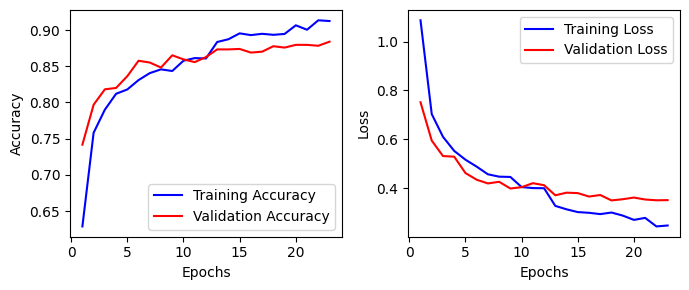

In [11]:
import matplotlib.pyplot as plt

# Retrieve model training and validation metrics from the history object
acc2 = history.history['accuracy'] #training accuracy
val_acc = history.history['val_accuracy'] #validation accuracy
loss2 = history.history['loss'] #training loss
val_loss = history.history['val_loss'] #validation loss

# Define the range for epochs
epochs = range(1,len(acc2)+1)

# Plot training and validation accuracy on the first subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# Plot training and validation accuracy on the first subplot
axes[0].plot(epochs, acc2, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot training and validation loss on the second subplot
axes[1].plot(epochs, loss2, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [12]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test dataset
y_pred = inception_model_tuning.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels from test_dataset
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate classification report with meaningful class names
report = classification_report(test_labels, y_pred_classes, target_names=class_names)
print(report)

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.89      0.94      0.91       214
                        Tomato_Early_blight       0.79      0.77      0.78       100
                         Tomato_Late_blight       0.89      0.91      0.90       191
                           Tomato_Leaf_Mold       0.84      0.84      0.84        96
                  Tomato_Septoria_leaf_spot       0.83      0.79      0.81       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.90      0.88      0.89       169
                        Tomato__Target_Spot       0.76      0.82      0.79       141
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.99      0.93      0.96       321
                Tomato__Tomato_mosaic_virus       0.90      0.92      0.91        38
                             Tomato_healthy       0.94      0.96      0.95       159

                       

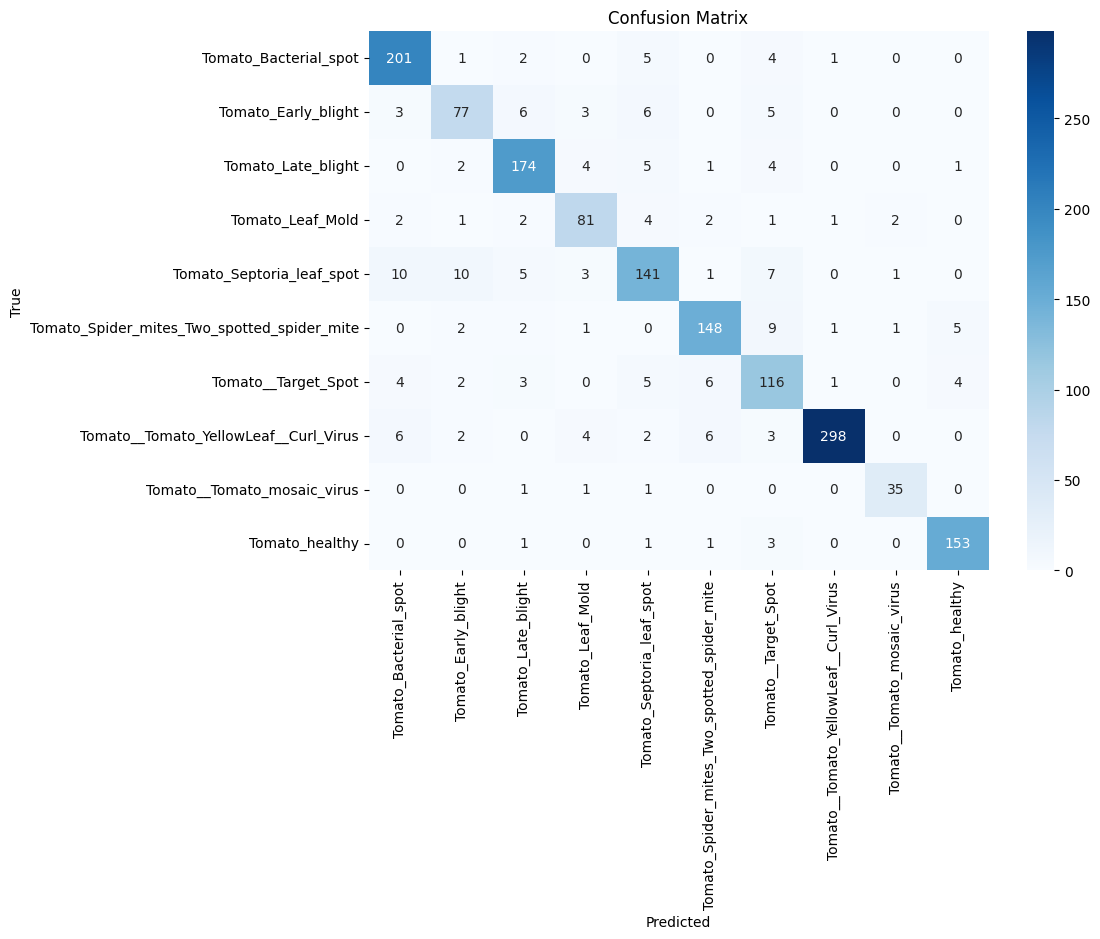

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## MobileNet

In [14]:
import keras_tuner as kt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define the model-building function
def build_model(hp):
    # Load the pre-trained InceptionV3 model
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    base_model.trainable = False  # Freeze the base model layers
    
    # Use Functional API to build the model
    inputs = tf.keras.Input(shape=(256, 256, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(hp.Float('dropout_rate_1', 0.3, 0.7, step=0.1))(x)
    x = layers.Dense(hp.Int('dense_units', 64, 256, step=32), activation='relu')(x)
    x = layers.Dropout(hp.Float('dropout_rate_2', 0.2, 0.5, step=0.1))(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy', 
    executions_per_trial=1, 
    max_trials=10,  # Number of random combinations to try
    directory='tuner_results',
    project_name='mobilenet_random_search'
)

/tmp/ipykernel_24/55182259.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Run the random search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Trial 10 Complete [00h 02m 59s]
val_accuracy: 0.9222570657730103

Best val_accuracy So Far: 0.951724112033844
Total elapsed time: 00h 29m 56s


In [16]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Dropout Rates: {best_hps.get('dropout_rate_1')}, {best_hps.get('dropout_rate_2')}")
print(f"Best Dense Units: {best_hps.get('dense_units')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

Best Dropout Rates: 0.3, 0.2
Best Dense Units: 96
Best Learning Rate: 0.001


In [17]:
# Build the best model using the optimal hyperparameters
mobilenet_model_tuning = tuner.hypermodel.build(best_hps)

# Train the best model
history = mobilenet_model_tuning.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

/tmp/ipykernel_24/55182259.py:11: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.5557 - loss: 1.3048 - val_accuracy: 0.8708 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8263 - loss: 0.5020 - val_accuracy: 0.9053 - val_loss: 0.2836 - learning_rate: 0.0010
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8683 - loss: 0.3942 - val_accuracy: 0.9241 - val_loss: 0.2293 - learning_rate: 0.0010
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8807 - loss: 0.3399 - val_accuracy: 0.9185 - val_loss: 0.2423 - learning_rate: 0.0010
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8941 - loss: 0.3047 - val_accuracy: 0.9329 - val_loss: 0.2102 - learning_rate: 0.0010
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9018 - loss: 0.2825 - val_accuracy: 0.9317 - val_loss: 0.2053 - learning_rate: 0.0010
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9152 - loss: 0

In [18]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = mobilenet_model_tuning.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9536 - loss: 0.1498
Test accuracy: 0.9533292055130005
Test loss: 0.1396866738796234


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate predictions for the test dataset
predictions = mobilenet_model_tuning.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1)  # Get the predicted class labels
true_classes = tf.concat([y for x, y in test_dataset], axis=0)  # True labels from the test dataset

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
Precision: 0.9536837207032184
Recall: 0.9533291848164281
F1 Score: 0.9532959449334714


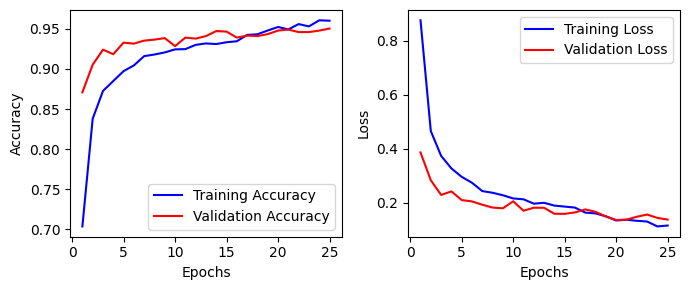

In [20]:
import matplotlib.pyplot as plt

# Retrieve model training and validation metrics from the history object
acc2 = history.history['accuracy'] #training accuracy
val_acc = history.history['val_accuracy'] #validation accuracy
loss2 = history.history['loss'] #training loss
val_loss = history.history['val_loss'] #validation loss

# Define the range for epochs
epochs = range(1,len(acc2)+1)

# Plot training and validation accuracy on the first subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

# Plot training and validation accuracy on the first subplot
axes[0].plot(epochs, acc2, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot training and validation loss on the second subplot
axes[1].plot(epochs, loss2, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

In [21]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on the test dataset
y_pred = mobilenet_model_tuning.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels from test_dataset
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Generate classification report with meaningful class names
report = classification_report(test_labels, y_pred_classes, target_names=class_names)
print(report)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.93      0.98      0.95       214
                        Tomato_Early_blight       0.93      0.92      0.92       100
                         Tomato_Late_blight       0.96      0.96      0.96       191
                           Tomato_Leaf_Mold       0.95      0.90      0.92        96
                  Tomato_Septoria_leaf_spot       0.95      0.94      0.95       178
Tomato_Spider_mites_Two_spotted_spider_mite       0.94      0.93      0.94       169
                        Tomato__Target_Spot       0.91      0.91      0.91       141
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.99      0.97      0.98       321
                Tomato__Tomato_mosaic_virus       0.93      0.97      0.95        38
                             Tomato_healthy       0.98      1.00      0.99       159

                       

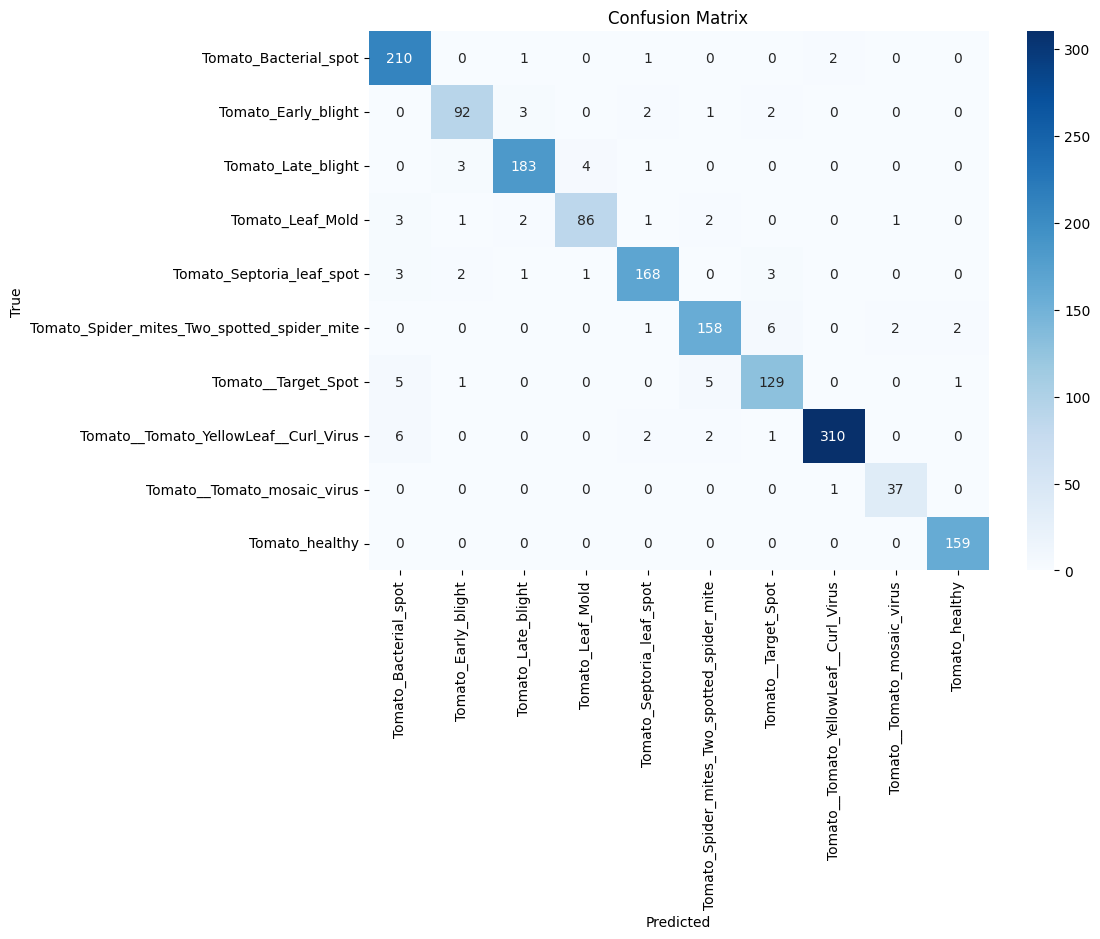

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()